## 第零步：准备工作，导入库，封装函数

In [2]:
'''
start: 2020-02-01 00:00:00
end: 2020-03-01 00:00:00
period: 1h
exchanges: [{"eid":"Huobi","currency":"BTC_USDT","stocks":0}]
'''
from __future__ import absolute_import, division, print_function
from fmz import * # 导入所有FMZ函数

#from pandas import *
import pandas as pd
import numpy as np

# Display and Plotting
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
#matplotlib.rcParams['axes.unicode_minus']=False # 解决负号显示异常的问题

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
from statsmodels.graphics.api import qqplot
from statsmodels.stats.diagnostic import acorr_ljungbox as lb_test

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from scipy import stats
# import arch
from arch import arch_model
import talib
import json
from urllib import request
from math import sqrt

from datetime import timedelta
from itertools import product
import warnings
warnings.simplefilter('ignore')

# %matplotlib inline
%config InlineBackend.figure_format = 'retina' # Increase chart resolution
# pd.set_option('display.float_format', lambda x: '%.5f' % x) # pandas
# np.set_printoptions(precision=5, suppress=True) # numpy
# pd.set_option('display.max_columns', 100)
# pd.set_option('display.max_rows', 100)

# seaborn plotting style
# sns.set(style='ticks', context='poster')

task = VCtx(__doc__) # 初始化
print(exchange.GetAccount())
print(exchange.GetTicker())
print(task.Join(True)) 

{'Balance': 10000.0, 'FrozenBalance': 0.0, 'Stocks': 0.0, 'FrozenStocks': 0.0}
{'Time': 1580486400000, 'High': 9337.10000001, 'Low': 9337.09999999, 'Sell': 9337.10000001, 'Buy': 9337.09999999, 'Last': 9337.1, 'Volume': 0.0, 'OpenInterest': 0.0}
                             close  balance  stocks  fee      net
2020-02-01 00:00:00+08:00      NaN  10000.0     0.0  0.0      NaN
2020-02-01 01:00:00+08:00  9286.70  10000.0     0.0  0.0  10000.0
2020-02-01 02:00:00+08:00  9282.80  10000.0     0.0  0.0  10000.0
2020-02-01 03:00:00+08:00  9318.21  10000.0     0.0  0.0  10000.0
2020-02-01 04:00:00+08:00  9303.98  10000.0     0.0  0.0  10000.0
2020-02-01 05:00:00+08:00  9324.05  10000.0     0.0  0.0  10000.0
2020-02-01 06:00:00+08:00  9364.94  10000.0     0.0  0.0  10000.0
2020-02-01 07:00:00+08:00  9402.93  10000.0     0.0  0.0  10000.0
2020-02-01 08:00:00+08:00  9351.66  10000.0     0.0  0.0  10000.0
2020-02-01 09:00:00+08:00  9383.17  10000.0     0.0  0.0  10000.0
2020-02-01 10:00:00+08:00  94

In [3]:
# 绘图函数
def pacfplot(y, lags=None, figsize=(18, 8)):
    fig = plt.figure(figsize=figsize)

    acf_ax = fig.add_subplot(2,1,1)  # ACF
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    plt.grid()

    pacf_ax = fig.add_subplot(2,1,2)  # PACF
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    plt.grid()
    
    sns.despine()
    plt.tight_layout()
    return acf_ax, pacf_ax

# 性能评价
def get_rmse(y, y_hat):
    '''Root Mean Square Error
    https://en.wikipedia.org/wiki/Root-mean-square_deviation
    '''
    mse = np.mean((y - y_hat)**2)
    return np.sqrt(mse)

def get_mape(y, y_hat):
    '''Mean Absolute Percent Error
    https://en.wikipedia.org/wiki/Mean_absolute_percentage_error
    '''
    perc_err = (100*(y - y_hat))/y
    return np.mean(abs(perc_err))

def get_mase(y, y_hat):
    '''Mean Absolute Scaled Error
    https://en.wikipedia.org/wiki/Mean_absolute_scaled_error
    '''
    abs_err = abs(y - y_hat)
    dsum=sum(abs(y[1:] - y_hat[1:]))
    t = len(y)
    denom = (1/(t - 1))* dsum
    return np.mean(abs_err/denom)

## 第零点五步：数据准备

In [4]:
# 准备训练样本集
# df = pd.DataFrame(get_bars('huobi.btc_usdt', '1h', count=5753, start='2019-06-01'))
df = get_bars('huobi.btc_usdt', '1h', count=3000, start='2019-11-01') # 5753
kline_all = pd.DataFrame(df['close'],dtype=np.float)
kline_all.index.name = 'date' #gs.tz_localize('US/Eastern').tz_convert('UTC').head() 时区转换
kline_all.index = pd.to_datetime(kline_all.index)  # 将字符串索引转换成时间索引
# kline_all['return'] = kline_all['close'].pct_change().dropna()  # 计算收益率
# kline_all['return_100x'] = np.multiply(kline_all['return'], 100)
kline_all['log_price'] = np.log(kline_all['close'])  # 计算每日对数收益率
kline_all['log_return'] = kline_all['log_price'] - kline_all['log_price'].shift(1)  # 计算对数收益率 =diff
kline_all['log_return_100x'] = np.multiply(kline_all['log_return'], 100)  # 放大100倍
kline_all['squared_log_return'] = np.power(kline_all['log_return_100x'], 2)  # 对数日收益率的指数平方
kline_all['realized_variance_1_hour'] = kline_all.loc[:, 'squared_log_return'].resample('h', closed='left', label='left').sum() # 重采样至天
kline_all['realized_volatility_1_hour'] = np.sqrt(kline_all['realized_variance_1_hour'])
# kline_all['return_dif_1'] = kline_all['log_return_100x'].diff(1)  # 差分处理
kline_all = kline_all[1:] # 由于最后一行缺失，因此去除最后一行
kline_train = kline_all[:2500]
# kline_all#.tail(3)
kline_train.tail()

,close,log_price,log_return,log_return_100x,squared_log_return,realized_variance_1_hour,realized_volatility_1_hour
date,,,,,,,
2020-02-13 00:00:00+08:00,10342.9,9.244056,0.002740,0.273993,0.075072,0.075072,0.273993
2020-02-13 01:00:00+08:00,10353.6,9.245090,0.001034,0.103399,0.010691,0.010691,0.103399
2020-02-13 02:00:00+08:00,10342.2,9.243988,-0.001102,-0.110167,0.012137,0.012137,0.110167
2020-02-13 03:00:00+08:00,10312.8,9.241141,-0.002847,-0.284677,0.081041,0.081041,0.284677
2020-02-13 04:00:00+08:00,10375.4,9.247193,0.006052,0.605178,0.366240,0.366240,0.605178


In [5]:
# 准备样本外数据，带已实现日波动率
df = get_bars('huobi.btc_usdt', '1m', count=50000, start='2020-02-13')  # 取分钟数据
kline_1m = pd.DataFrame(df['close'], dtype=np.float)
kline_1m.index.name = 'date'
kline_1m['log_price'] = np.log(kline_1m['close'])
kline_1m['log_return'] = kline_1m['log_price'] - kline_1m['log_price'].shift(1)
kline_1m['log_return_100x'] = np.multiply(kline_1m['log_return'], 100)  # 放大100倍
kline_1m['squared_log_return'] = np.power(kline_1m['log_return_100x'], 2)
kline_1m#.tail()
df = get_bars('huobi.btc_usdt', '1h', count=860, start='2020-02-13')  # 取小时数据
kline_test = pd.DataFrame(df['close'], dtype=np.float)
kline_test.index.name = 'date'
kline_test['log_price'] = np.log(kline_test['close'])  # 计算每日对数收益率
kline_test['log_return'] = kline_test['log_price'] - kline_test['log_price'].shift(1)  # 计算对数收益率
kline_test['log_return_100x'] = np.multiply(kline_test['log_return'], 100)  # 放大100倍
kline_test['squared_log_return'] = np.power(kline_test['log_return_100x'], 2)  # 对数日收益率的指数平方
kline_test['realized_variance_1_hour'] = kline_1m.loc[:, 'squared_log_return'].resample('h', closed='left', label='left').sum() # 重采样至天
kline_test['realized_volatility_1_hour'] = np.sqrt(kline_test['realized_variance_1_hour'])  # 方差开方得波动率
kline_test = kline_test[4:-2] # 由于最后一行缺失，因此去除最后一行
kline_test#.head(3)

training_ts = pd.DataFrame(kline_train['log_price'], dtype=np.float)
testing_ts = pd.DataFrame(kline_test['log_price'], dtype=np.float)
training_label = 'log_price'
training_ts.tail()

,log_price
date,
2020-02-13 00:00:00+08:00,9.244056
2020-02-13 01:00:00+08:00,9.245090
2020-02-13 02:00:00+08:00,9.243988
2020-02-13 03:00:00+08:00,9.241141
2020-02-13 04:00:00+08:00,9.247193


## 第七步 ARCH效应检验

#### 全局变量

In [6]:
model_lags = 1
model_p = 2
predict_lag = 200
training_arch_label = 'log_return_100x'
training_arch = pd.DataFrame(kline_train[training_arch_label], dtype=np.float)
testing_arch = pd.DataFrame(kline_test[training_arch_label], dtype=np.float)

training_garch_label = 'log_return_100x'
training_garch = pd.DataFrame(kline_train[training_garch_label], dtype=np.float)
testing_garch = pd.DataFrame(kline_test[training_garch_label], dtype=np.float)

training_egarch_label = 'log_return_100x'
training_egarch = pd.DataFrame(kline_train[training_egarch_label], dtype=np.float)
testing_egarch = pd.DataFrame(kline_test[training_egarch_label], dtype=np.float)

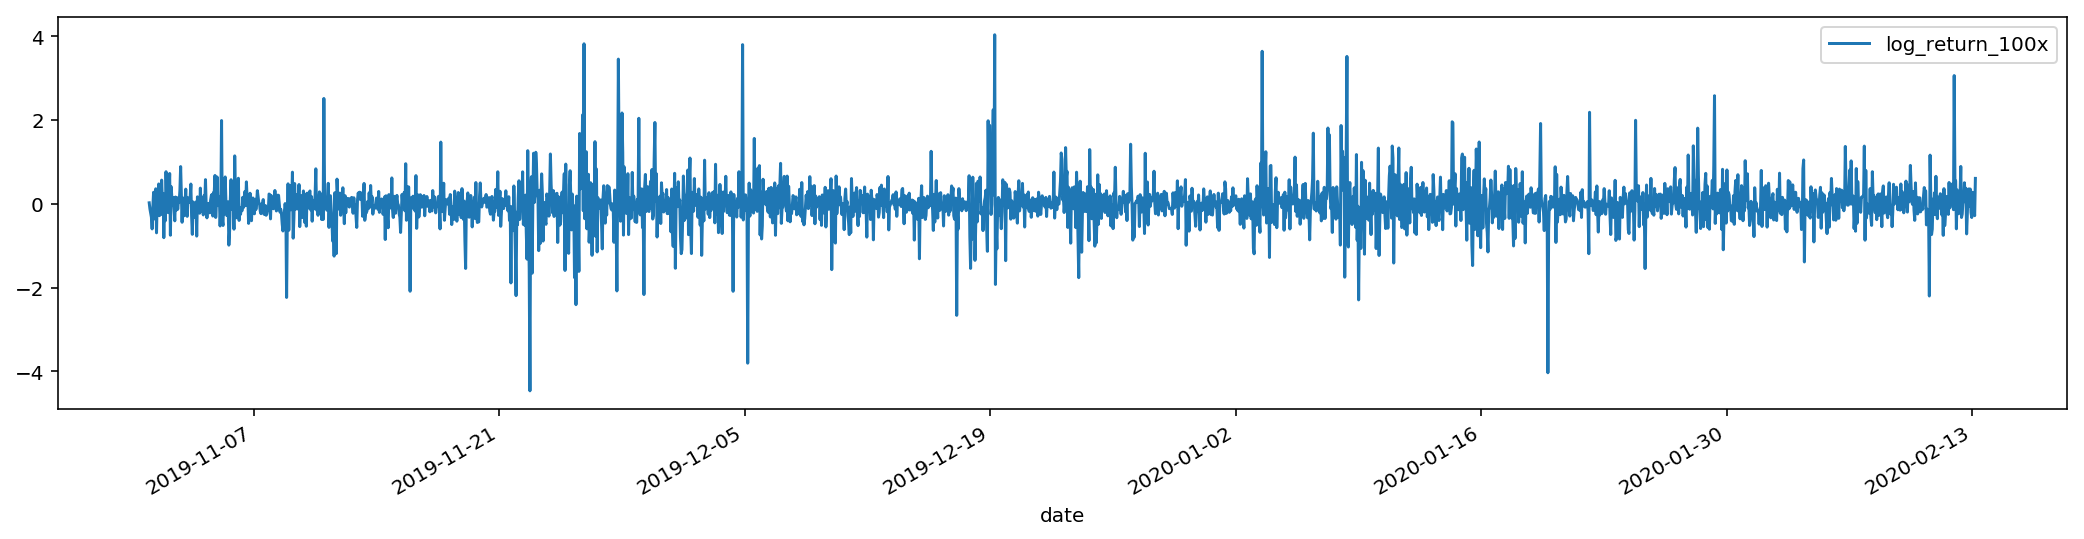

In [83]:
# ARCH 数据集
training_arch.plot(figsize = (18,4))

#### 误差项、正太和方差检验

In [20]:
t = sm.tsa.stattools.adfuller(training_arch[training_arch_label])  # ADF检验
print("p-value:   ",t[1])
#原假设H0：序列为非平稳的，备择假设H1:序列是平稳的
# p-value小于显著性水平，拒绝原假设，因此序列是平稳的，接下来我们建立AR(p)模型，先判定阶次

p-value:    1.523289958873227e-17


(<matplotlib.axes._subplots.AxesSubplot at 0x1c3a570f98>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1c3a5adc18>)

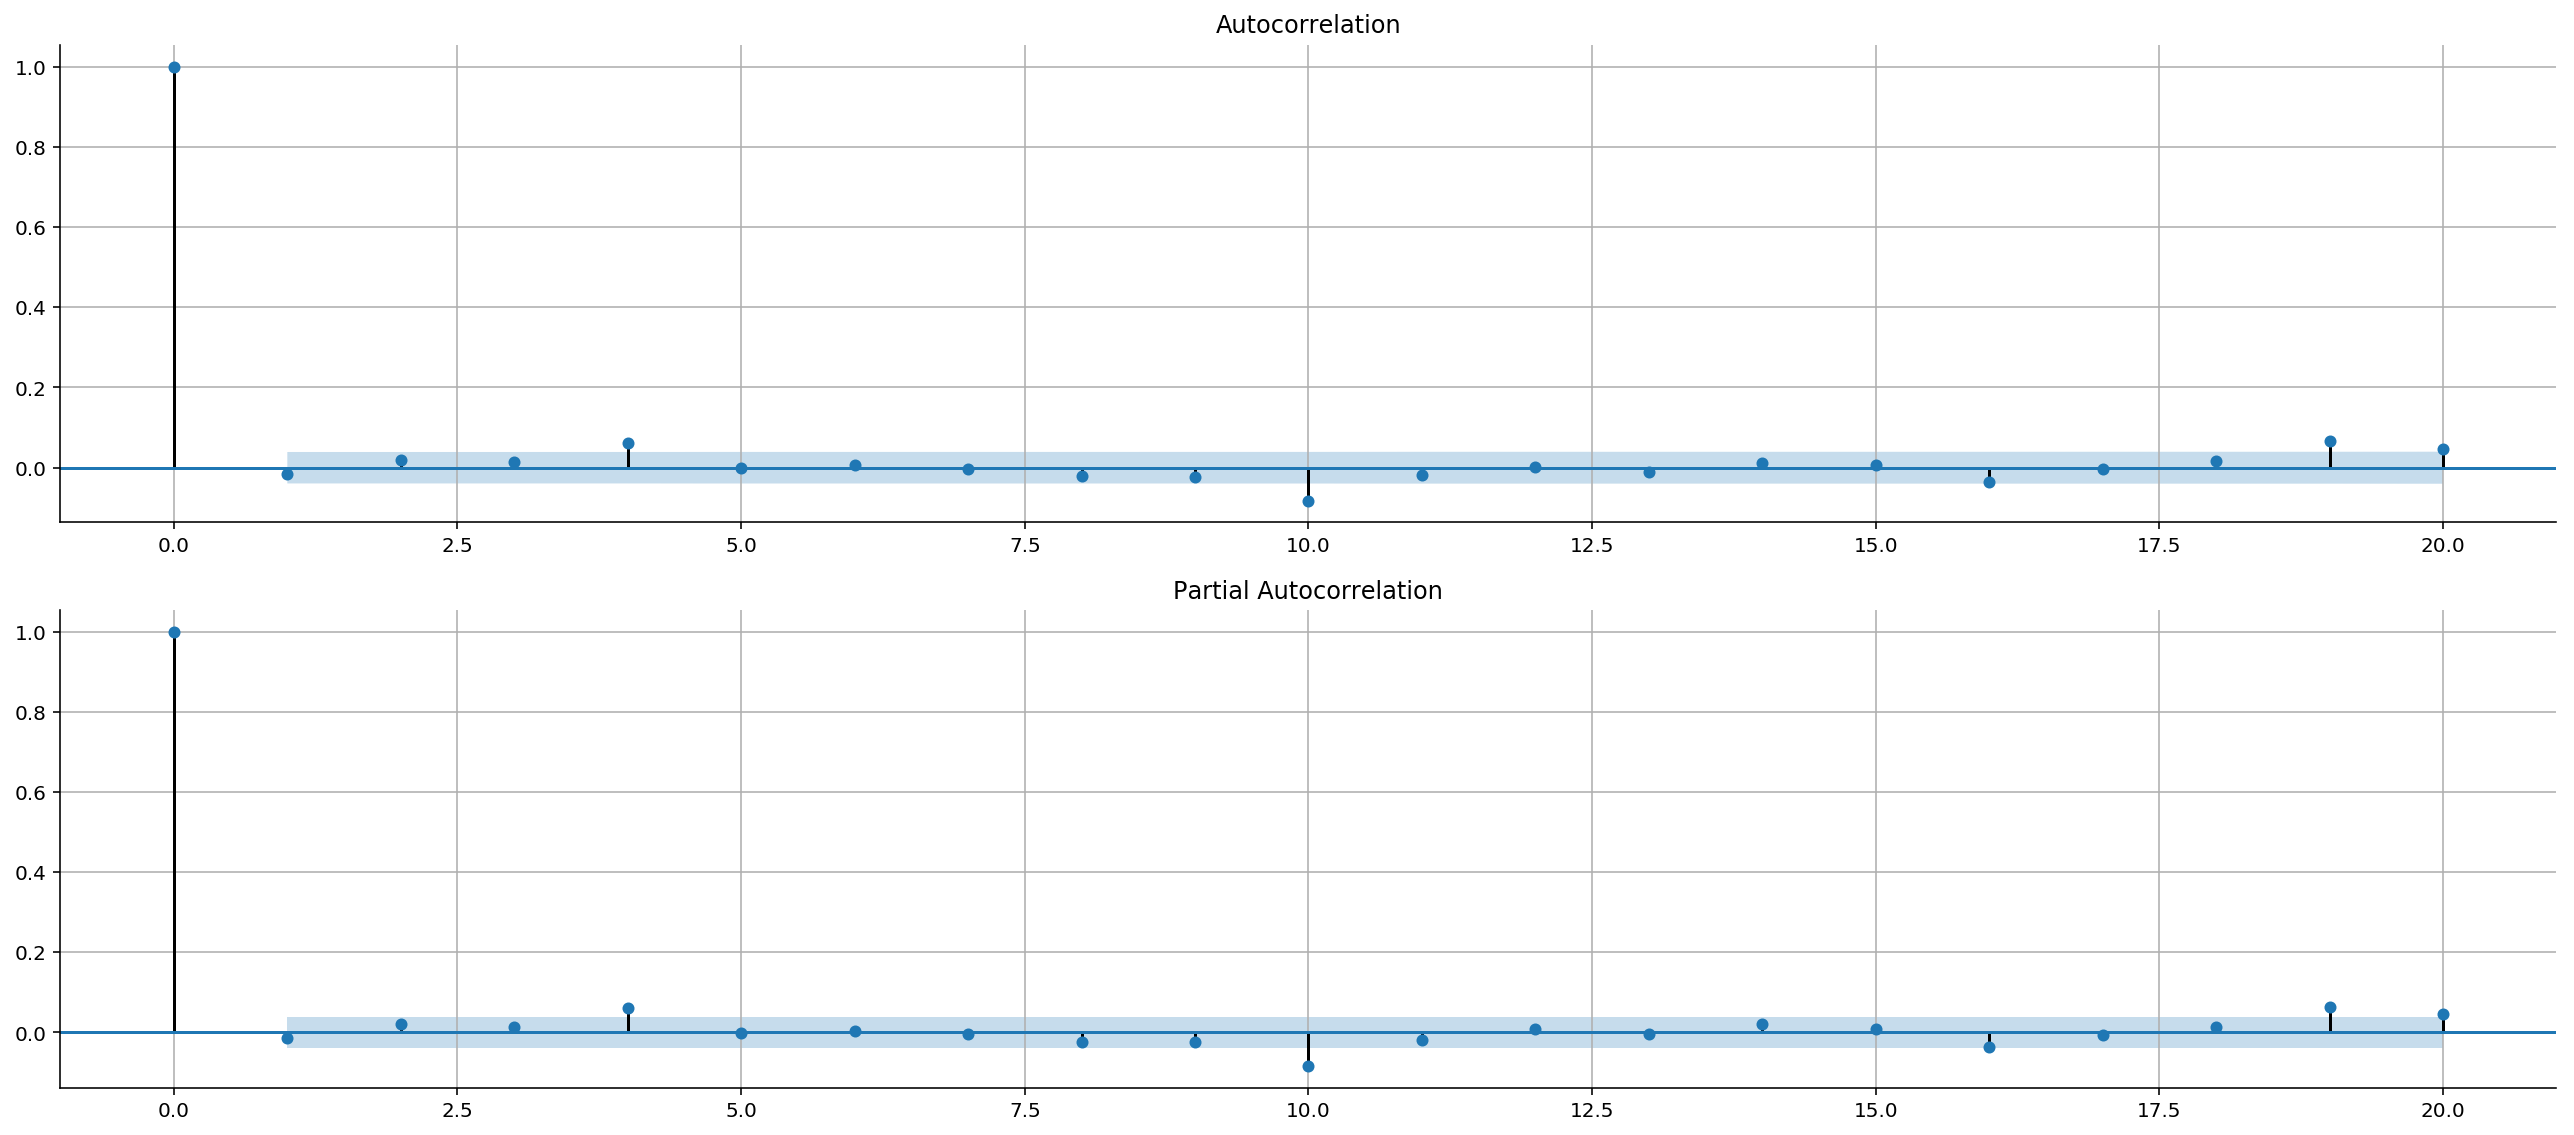

In [190]:
# p<0.05, 认为序列是平稳的，建立AR(p)模型，并判断阶数 
# PACF- AR(p) ACF- MA(q)
pacfplot(training_arch,lags=20)

#### 建立ARIMA均值模型

In [8]:
training_arma_model = smt.SARIMAX(endog=training_ts, trend='c', order=(1, 2, 1), 
                             seasonal_order=(1, 1, 2, 12)#, 
#                              simple_differencing=False,
#                              enforce_stationarity=False,
#                              enforce_invertibility=False
                            )
arch_model_results = training_arma_model.fit(disp=False)
arch_model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                          log_price   No. Observations:                 2500
Model:             SARIMAX(1, 2, 1)x(1, 1, 2, 12)   Log Likelihood                9245.213
Date:                            Sat, 14 Mar 2020   AIC                         -18476.426
Time:                                    00:34:33   BIC                         -18435.697
Sample:                                11-01-2019   HQIC                        -18461.635
                                     - 02-13-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -4.892e-06   4.02e-06     -1.217      0.224   -1.28e-05    2.99e-06
ar.L1         -0.0440      0.018     -2.405      0.016      -0.080      -0.008
ma.L1         -0.7522      0.014    -54.781      0.000      -0.779      -0.725
ar.S.L12      -0.4748      0.103     -4.629      0.000      -0.676      -0.274
ma.S.L12      -0.3307      0.098     -3.369      0.001      -0.523      -0.138
ma.S.L24      -0.5403      0.084     -6.406      0.000      -0.706      -0.375
sigma2      3.427e-05   4.48e-07     76.499      0.000    3.34e-05    3.51e-05
===================================================================================
Ljung-Box (Q):                      183.34   Jarque-Bera (JB):              6919.40
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.71   Skew:                             0.13
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [9]:
# ARCH效应检验 并作出残差和残差平方图像：
training_arch_fitvalue = pd.DataFrame(arch_model_results.fittedvalues,dtype=np.float)
at = pd.merge(training_arch, training_arch_fitvalue, on='date')
at.columns = ['log_return_100x', 'arch_model']
at['res'] = at['log_return_100x'] - at['arch_model']
at['res2'] = np.square(at['res'])
at.head()

,log_return_100x,arch_model,res,res2
date,,,,
2019-11-01 01:00:00+08:00,0.022396,-0.000003,0.022400,0.000502
2019-11-01 02:00:00+08:00,-0.124271,15.219468,-15.343740,235.430354
2019-11-01 03:00:00+08:00,-0.229680,9.129194,-9.358875,87.588540
2019-11-01 04:00:00+08:00,-0.322855,9.125844,-9.448699,89.277912
2019-11-01 05:00:00+08:00,-0.600411,9.121683,-9.722095,94.519125


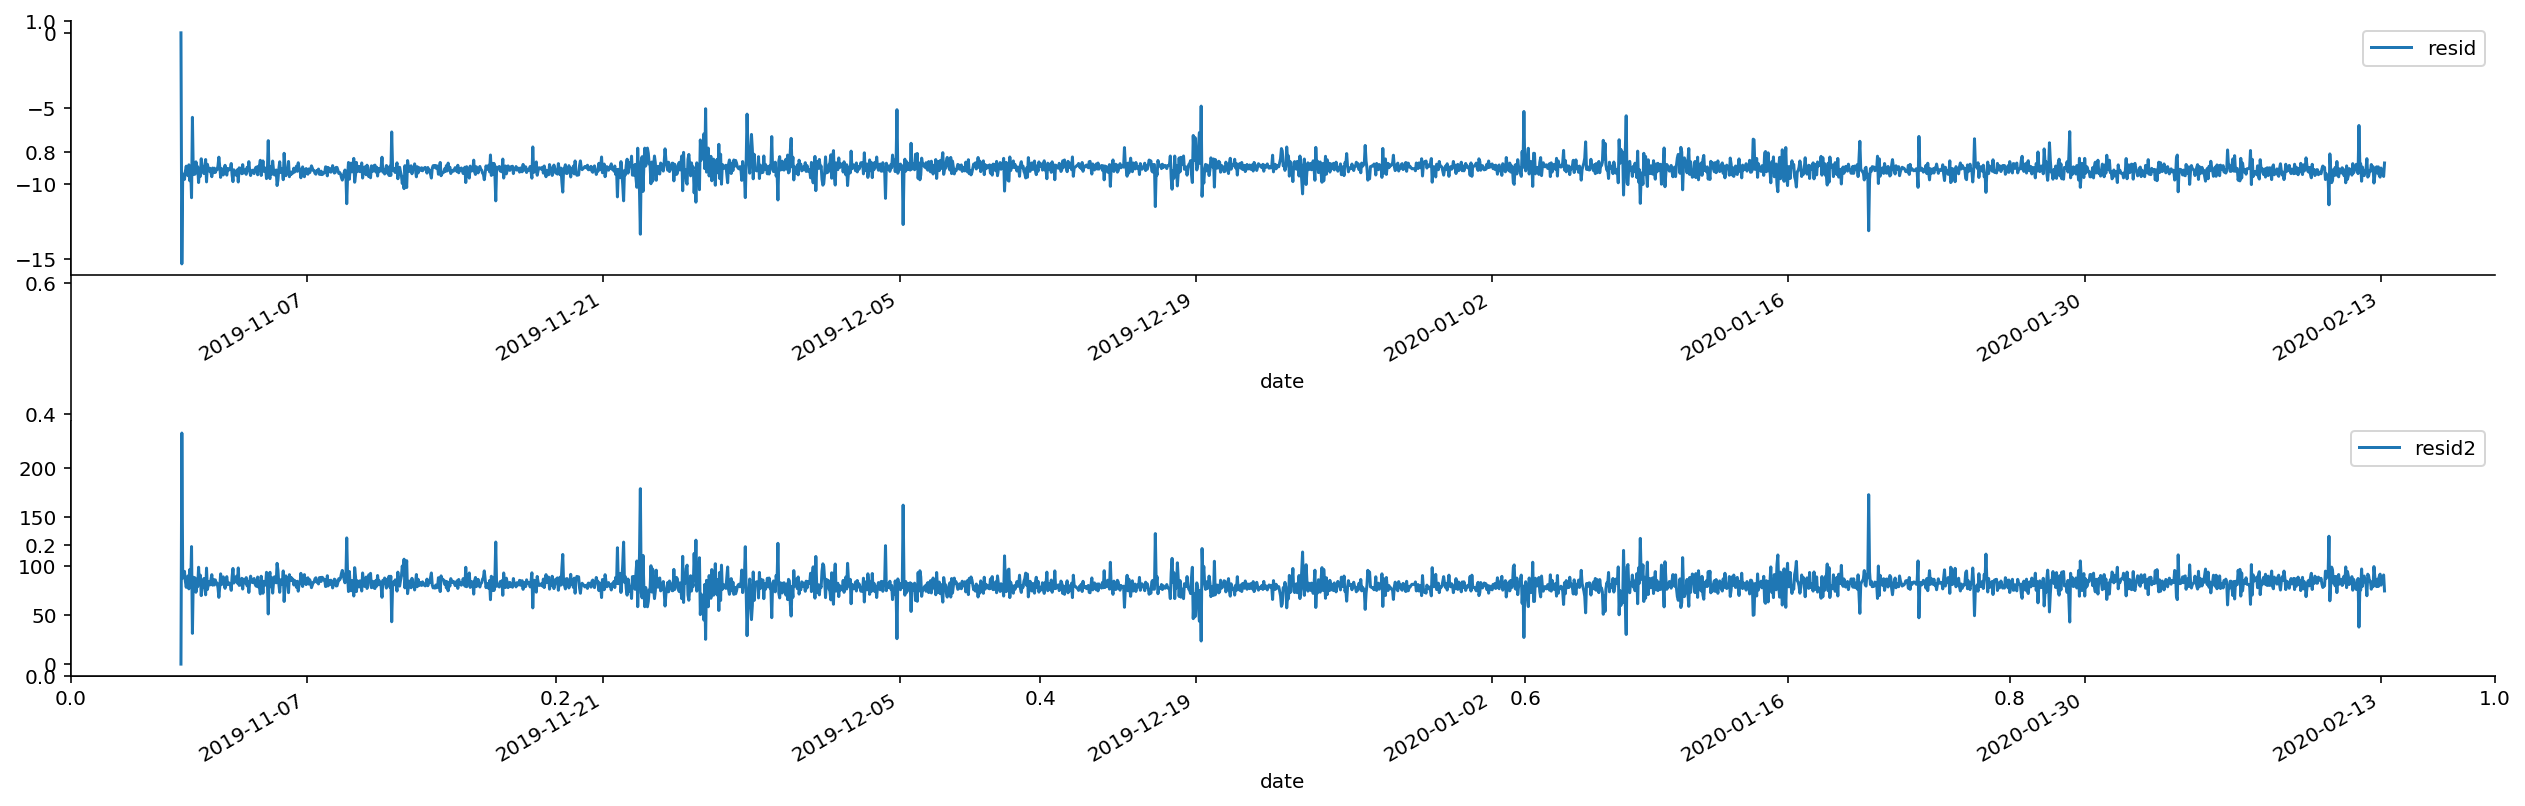

In [14]:
fig, ax = plt.subplots(figsize=(18, 6))
ax1 = fig.add_subplot(2,1,1)
at['res'].plot(ax=ax1,label='resid')
plt.legend(loc='best')

ax2 = fig.add_subplot(2,1,2)
at['res2'].plot(ax=ax2,label='resid2')

plt.legend(loc='best')
plt.tight_layout()
sns.despine()

In [15]:
# 对{a2t}序列进行混成检验： 原假设H0:序列没有相关性，备择假设H1:序列具有相关性
acf,q,p = sm.tsa.acf(at['res2'],nlags=20,qstat=True)  ## 计算自相关系数及p-value
out = np.c_[range(1,21), acf[1:], q, p]
output=pd.DataFrame(out, columns=['lag', "AC", "Q", "P-value"])
output = output.set_index('lag')
output  # p<0.05，认为残差序列具有相关性，符合异方差的假设，因此具有ARCH效应。

,AC,Q,P-value
lag,,,
1.0,-0.035047,3.074460,7.953099e-02
2.0,0.045433,8.243043,1.621982e-02
3.0,0.041125,12.479684,5.908238e-03
4.0,0.080968,28.908805,8.158025e-06
5.0,0.016744,29.611684,1.758465e-05
6.0,0.030231,31.903797,1.702527e-05
7.0,0.027856,33.850729,1.836851e-05
8.0,0.008239,34.021100,4.027050e-05
9.0,0.013430,34.473994,7.374858e-05


## 第八步 建立ARCH模型

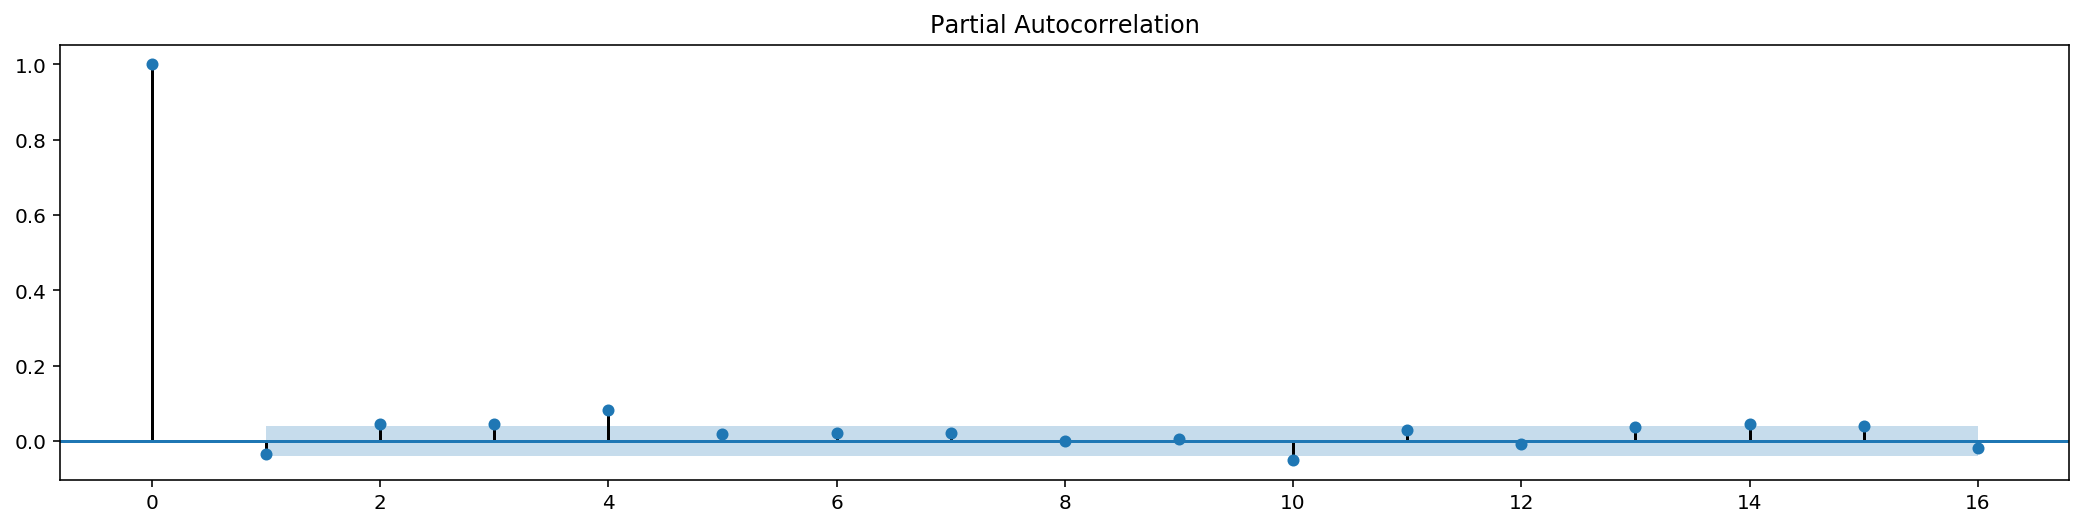

In [16]:
# 用$\{ a^2_t \}$序列偏自相关函数（pACF）确定：
figure = plt.figure(figsize=(18,4))
ax1 = figure.add_subplot(111)
fig = sm.graphics.tsa.plot_pacf(at['res2'],lags = 16, ax=ax1) # P = 6

#### ARCH模型建立

In [75]:
# trained_ARCH = arch_model(training_arch, mean='AR', lags=model_lags, vol='ARCH', p=model_p)
trained_ARCH = arch_model(training_arch, mean='AR', vol='ARCH',p=model_lags, dist='ged')
res_ARCH = trained_ARCH.fit()
res_ARCH.summary()  # 得到模型

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1648.8082750981253
Iteration:      2,   Func. Count:     16,   Neg. LLF: 1648.7549368005052
Iteration:      3,   Func. Count:     23,   Neg. LLF: 1618.0755878724776
Iteration:      4,   Func. Count:     30,   Neg. LLF: 1555.6312422461415
Iteration:      5,   Func. Count:     36,   Neg. LLF: 1482.7631939233388
Iteration:      6,   Func. Count:     43,   Neg. LLF: 1479.0898856193962
Iteration:      7,   Func. Count:     50,   Neg. LLF: 1472.5831163382495
Iteration:      8,   Func. Count:     56,   Neg. LLF: 1472.1881924448496
Iteration:      9,   Func. Count:     62,   Neg. LLF: 1472.0485157657445
Iteration:     10,   Func. Count:     68,   Neg. LLF: 1472.043739167244
Iteration:     11,   Func. Count:     74,   Neg. LLF: 1472.043709936846
Iteration:     12,   Func. Count:     80,   Neg. LLF: 1472.043693813103
Iteration:     13,   Func. Count:     87,   Neg. LLF: 1472.043692349255
Iteration:     14,   Func. Count:     94,   Neg. LLF: 1

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 AR - ARCH Model Results                                  
==========================================================================================
Dep. Variable:                    log_return_100x   R-squared:                      -0.000
Mean Model:                                    AR   Adj. R-squared:                 -0.000
Vol Model:                                   ARCH   Log-Likelihood:               -1472.04
Distribution:      Generalized Error Distribution   AIC:                           2952.09
Method:                        Maximum Likelihood   BIC:                           2975.38
                                                    No. Observations:                 2500
Date:                            Sat, Mar 14 2020   Df Residuals:                     2496
Time:                                    12:35:58   Df Model:                            4
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
Const      3.8263e-03  1.344e-03      2.848  4.401e-03 [1.193e-03,6.460e-03]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.1706  1.356e-02     12.582  2.667e-36 [  0.144,  0.197]
alpha[1]       0.3107  6.672e-02      4.656  3.226e-06 [  0.180,  0.441]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             1.0100  5.140e-02     19.651  5.662e-86 [  0.909,  1.111]
========================================================================

Covariance estimator: robust
"""

Iteration:      1,   Func. Count:      6,   Neg. LLF: 143.46497947776584
Iteration:      2,   Func. Count:     16,   Neg. LLF: 143.39778825276187
Iteration:      3,   Func. Count:     23,   Neg. LLF: 140.9630940472153
Iteration:      4,   Func. Count:     30,   Neg. LLF: 139.5977029855437
Iteration:      5,   Func. Count:     36,   Neg. LLF: 134.47147293669363
Iteration:      6,   Func. Count:     43,   Neg. LLF: 134.3773451780455
Iteration:      7,   Func. Count:     50,   Neg. LLF: 134.25860743875614
Iteration:      8,   Func. Count:     56,   Neg. LLF: 134.18322937183655
Iteration:      9,   Func. Count:     62,   Neg. LLF: 134.18147167097197
Iteration:     10,   Func. Count:     68,   Neg. LLF: 134.18140341990707
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 134.18140341993154
            Iterations: 10
            Function evaluations: 68
            Gradient evaluations: 10


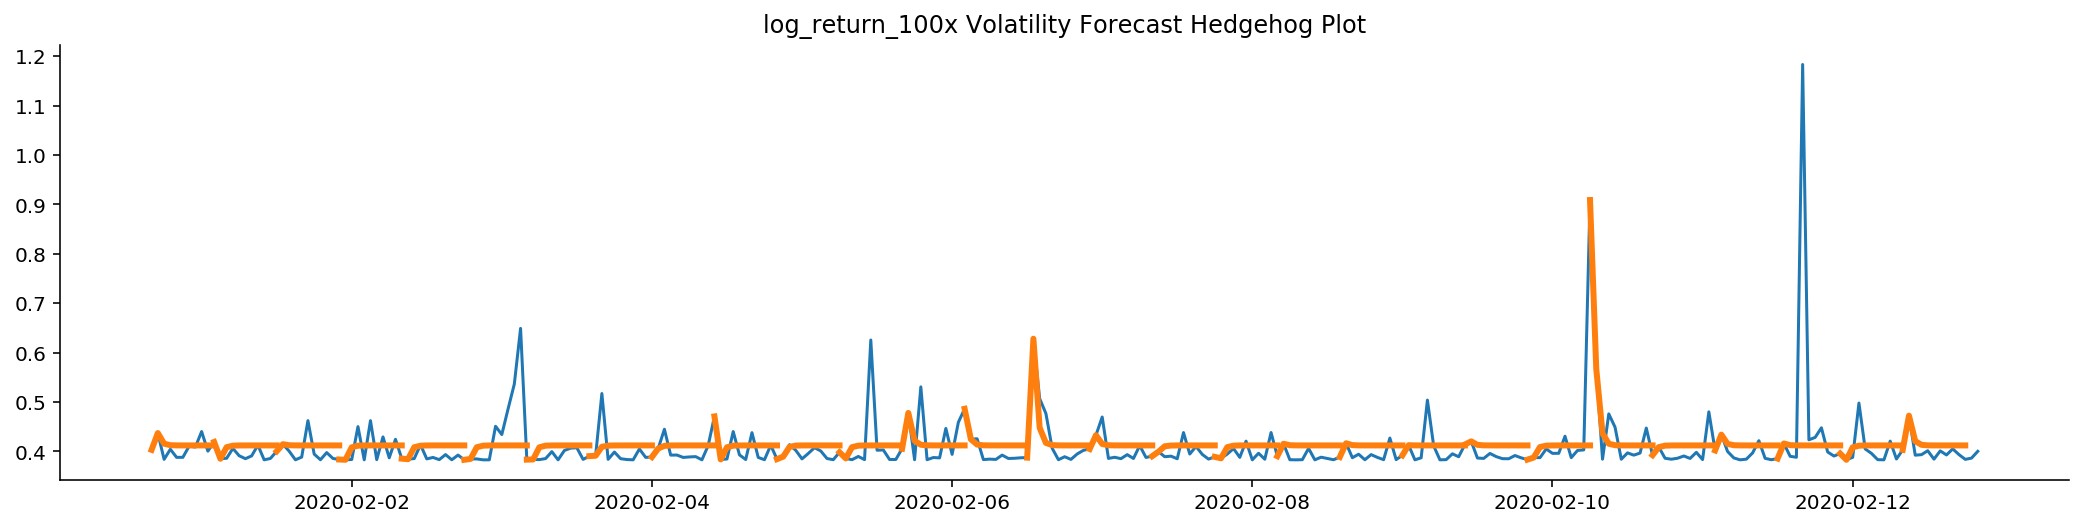

In [62]:
start_date = '2020-02-01 00:00:00+08:00'
trained_ARCH2 = arch_model(training_arch.loc[start_date:], mean='AR', vol='ARCH',p=model_lags, dist='ged')
res_ARCH = trained_ARCH2.fit()
fig = res_ARCH.hedgehog_plot()  # volatility
fig.set_size_inches(18, 4)
sns.despine()

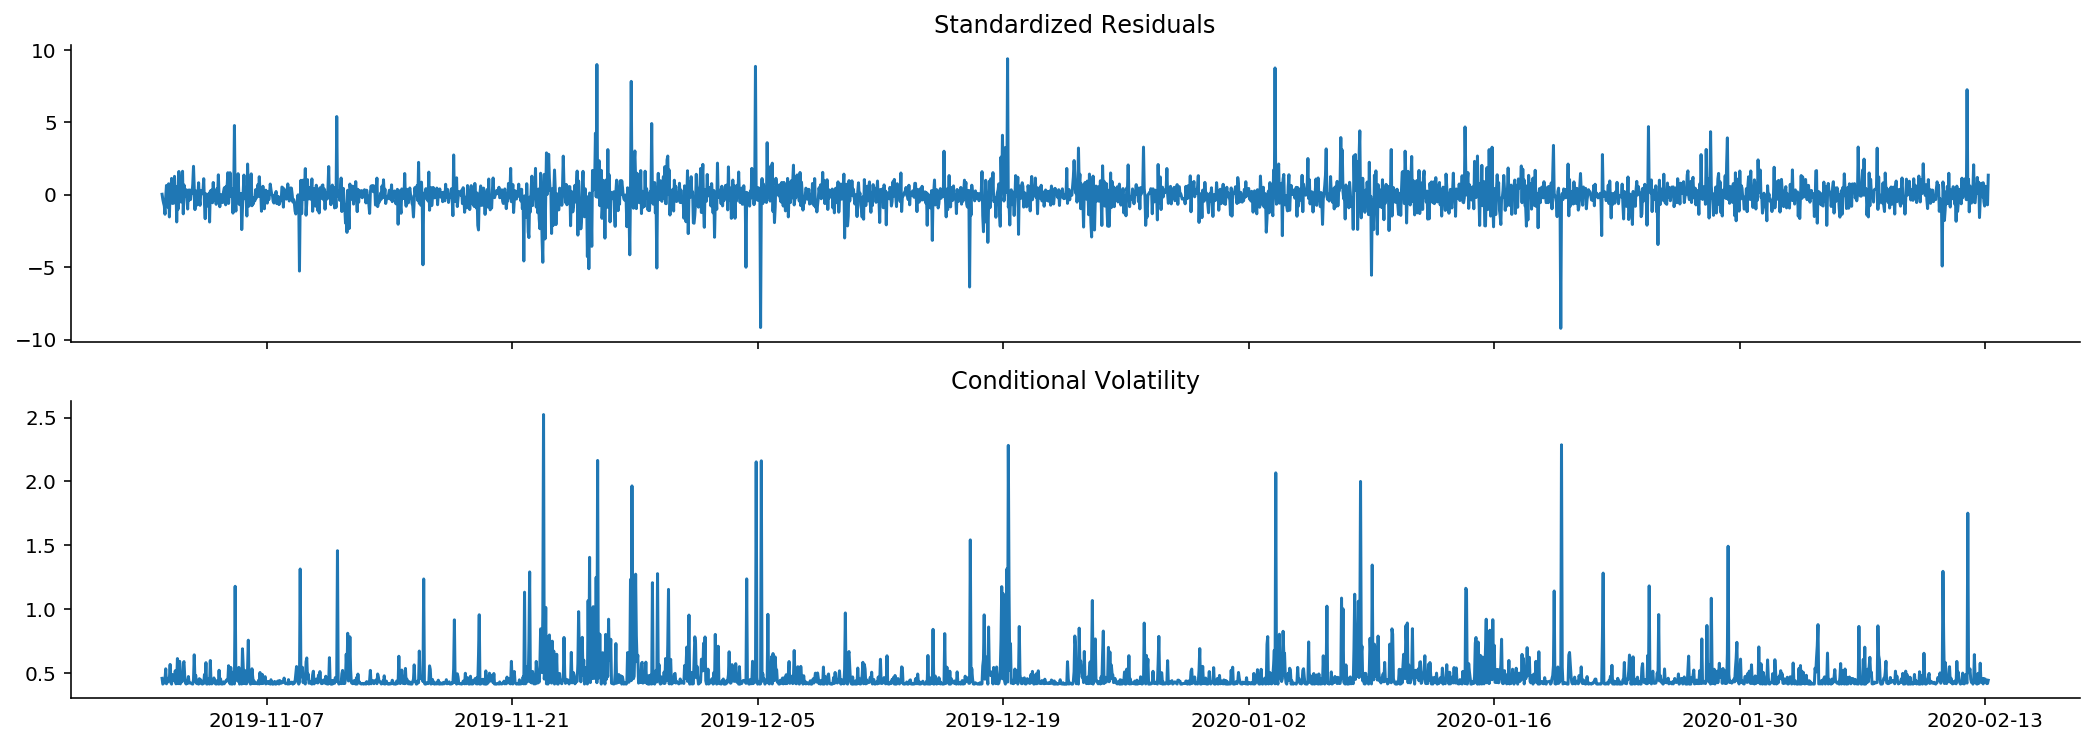

In [76]:
fig = res_ARCH.plot()# standardized residual
fig.set_size_inches(18, 6)# conditional volatility
sns.despine()

In [20]:
# len(training_arch)
pre_ARCH = res_ARCH.forecast(horizon=5, start=2400, method='simulation')
# pre_ARCH.variance[2400:]#.plot()

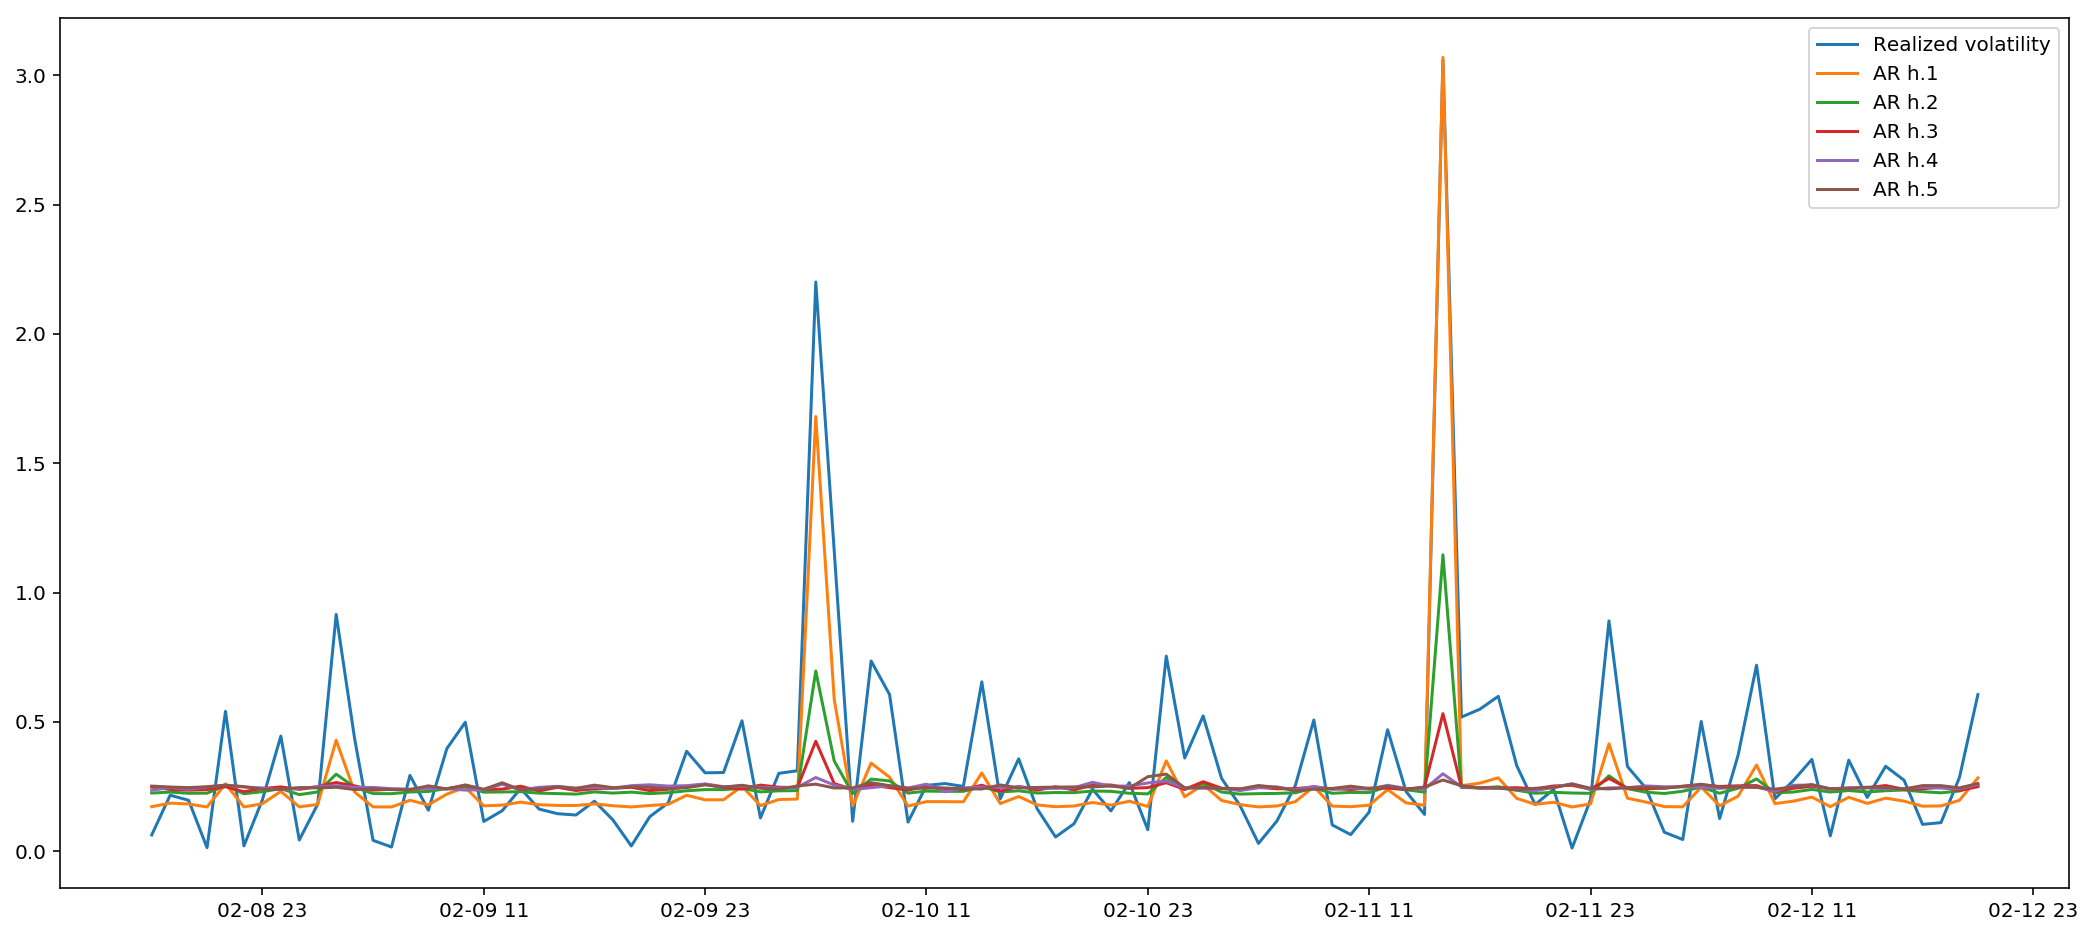

In [21]:
plt.figure(figsize=(18,8))
plt.plot(kline_train['realized_volatility_1_hour'][2400:],label='Realized volatility')
plt.plot(pre_ARCH.variance[2400:]['h.1'], label='AR h.1')
plt.plot(pre_ARCH.variance[2400:]['h.2'], label='AR h.2')
plt.plot(pre_ARCH.variance[2400:]['h.3'], label='AR h.3')
plt.plot(pre_ARCH.variance[2400:]['h.4'], label='AR h.4')
plt.plot(pre_ARCH.variance[2400:]['h.5'], label='AR h.5')
# plt.plot(np.zeros(10),label='zero')s
plt.legend()

In [22]:
res_ARCH.params #https://uqer.io/v3/community/share/57aac592228e5b9b95a88999
# 日收益率期望大约为-0.04%，根据AdjR²值，模型拟合效果一般

Const       0.003826
omega       0.170628
alpha[1]    0.310658
nu          1.010000
Name: params, dtype: float64

#### ARCH预测

ARCH模型
            $$a_t = \sigma_t \epsilon_t \\
              \sigma^2_t = \alpha_0 + \alpha_1 a^2_{t-1} + \cdots + \alpha_m a^2_{t-m}$$
其中，$\{ \epsilon_t \}$是均值为0，方差为1的独立同分布随机变量序列，$\alpha_0 >0, \alpha_1, \cdots, \alpha_m \geq 0$.

In [71]:
# ini = res_ARCH.resid[-model_lags:]  # 提取均值方程的系数向量，逐个计算 𝑎𝑡 后面的20个值
# a = np.array(res_ARCH.params[1:2])
# w = a[::-1] # 系数
# for i in range(predict_lag):
#     new = testing_arch.iloc[i] - (res_ARCH.params[0] + w.dot(ini[-1:]))
#     ini = np.append(ini,new)
# at_pre = ini[-predict_lag:]
# at_pre2 = at_pre**2
# # at_pre2
# ini2 = res_ARCH.conditional_volatility[-2:] #上两个条件异方差值 根据波动率方程预测 𝜎2
for i in range(predict_lag):
#     new = res_ARCH.params['omega'] + res_ARCH.params['alpha[1]']*at_pre2[i]
    new = res_ARCH.params['omega'] + res_ARCH.params['alpha[1]'] * res_GARCH.resid**2
    ini2 = np.append(ini2,new)
vol_pre = ini2[-predict_lag:]
# vol_pre
compare_ARCH = pd.DataFrame()
compare_ARCH['original'] = kline_test['realized_volatility_1_hour'][:predict_lag-model_p]
compare_ARCH['predict_volatility'] = vol_pre[model_p:]
compare_ARCH.head()

,original,predict_volatility
date,,
2020-02-13 04:00:00+08:00,0.440438,0.195345
2020-02-13 05:00:00+08:00,0.446989,0.155515
2020-02-13 06:00:00+08:00,0.251623,0.146556
2020-02-13 07:00:00+08:00,0.513761,0.167271
2020-02-13 08:00:00+08:00,0.420905,0.148029


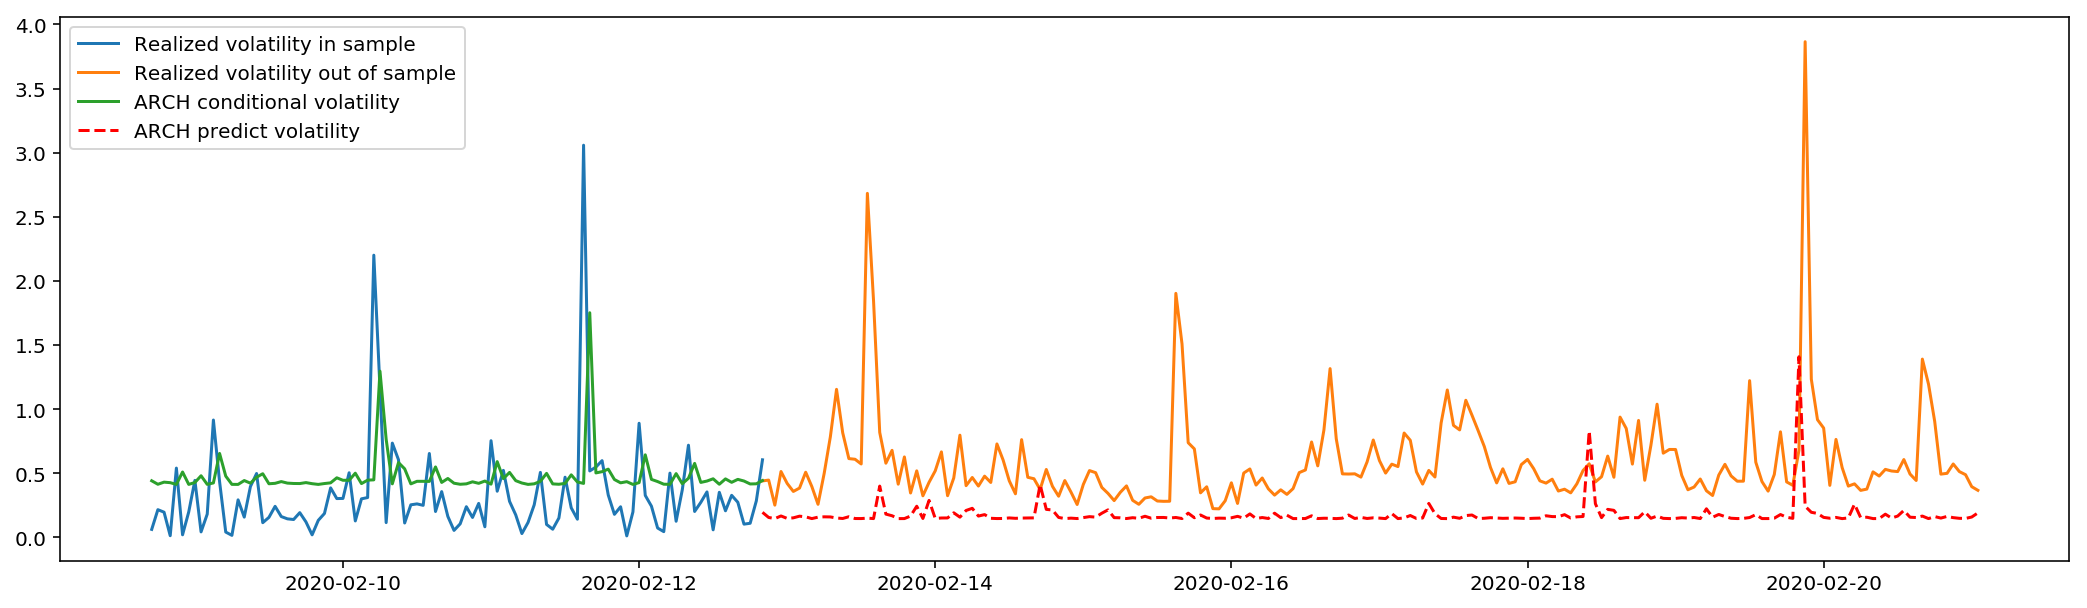

In [77]:
plt.figure(figsize=(18,5))
plt.plot(kline_train['realized_volatility_1_hour'][2400:],label='Realized volatility in sample')
plt.plot(compare_ARCH['original'], label='Realized volatility out of sample')
plt.plot(res_ARCH.conditional_volatility[2400:],label='ARCH conditional volatility')
plt.plot(compare_ARCH['predict_volatility'], '--r', label='ARCH predict volatility')
plt.legend()

## 第九步 建立GARCH模型

In [66]:
#GARCH模型 以之前的数据为例，构建GARCH模型，均值方程取AR(4)模型，波动率方程取GARCH(1,1)模型
am_GARCH = arch_model(training_garch, mean='AR',lags=model_lags, vol='GARCH', 
                      p=model_lags, o=0, q=1, dist='ged',power=2.0)
res_GARCH = am_GARCH.fit()
res_GARCH.summary()

Iteration:      1,   Func. Count:      8,   Neg. LLF: 1552.7093554146013
Iteration:      2,   Func. Count:     20,   Neg. LLF: 1547.6270790668264
Iteration:      3,   Func. Count:     33,   Neg. LLF: 1545.1403276189217
Iteration:      4,   Func. Count:     43,   Neg. LLF: 1540.8473050131092
Iteration:      5,   Func. Count:     51,   Neg. LLF: 1518.9261674107943
Iteration:      6,   Func. Count:     61,   Neg. LLF: 1491.7947466189112
Iteration:      7,   Func. Count:     70,   Neg. LLF: 1459.0540921709267
Iteration:      8,   Func. Count:     79,   Neg. LLF: 1445.9515033017856
Iteration:      9,   Func. Count:     88,   Neg. LLF: 1441.3407201478722
Iteration:     10,   Func. Count:     97,   Neg. LLF: 1435.720733700105
Iteration:     11,   Func. Count:    106,   Neg. LLF: 1431.2083407382797
Iteration:     12,   Func. Count:    115,   Neg. LLF: 1425.8713255662858
Iteration:     13,   Func. Count:    124,   Neg. LLF: 1421.9698046148296
Iteration:     14,   Func. Count:    133,   Neg. LLF

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 AR - GARCH Model Results                                 
==========================================================================================
Dep. Variable:                    log_return_100x   R-squared:                      -0.008
Mean Model:                                    AR   Adj. R-squared:                 -0.009
Vol Model:                                  GARCH   Log-Likelihood:               -1405.49
Distribution:      Generalized Error Distribution   AIC:                           2822.97
Method:                        Maximum Likelihood   BIC:                           2857.92
                                                    No. Observations:                 2499
Date:                            Sat, Mar 14 2020   Df Residuals:                     2493
Time:                                    12:32:15   Df Model:                            6
                                   Mean Model                                  
===============================================================================
                    coef    std err          t      P>|t|      95.0% Conf. Int.
-------------------------------------------------------------------------------
Const         3.2734e-03  3.147e-04     10.402  2.439e-25 [2.657e-03,3.890e-03]
log_...00x[1]    -0.1064  3.212e-04   -331.350      0.000     [ -0.107, -0.106]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.0166  8.510e-03      1.950  5.122e-02 [-8.796e-05,3.327e-02]
alpha[1]       0.1091  4.619e-02      2.363  1.813e-02    [1.861e-02,  0.200]
beta[1]        0.8156  7.539e-02     10.819  2.796e-27      [  0.668,  0.963]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             1.0100  4.666e-02     21.646 6.666e-104 [  0.919,  1.101]
========================================================================

Covariance estimator: robust
"""

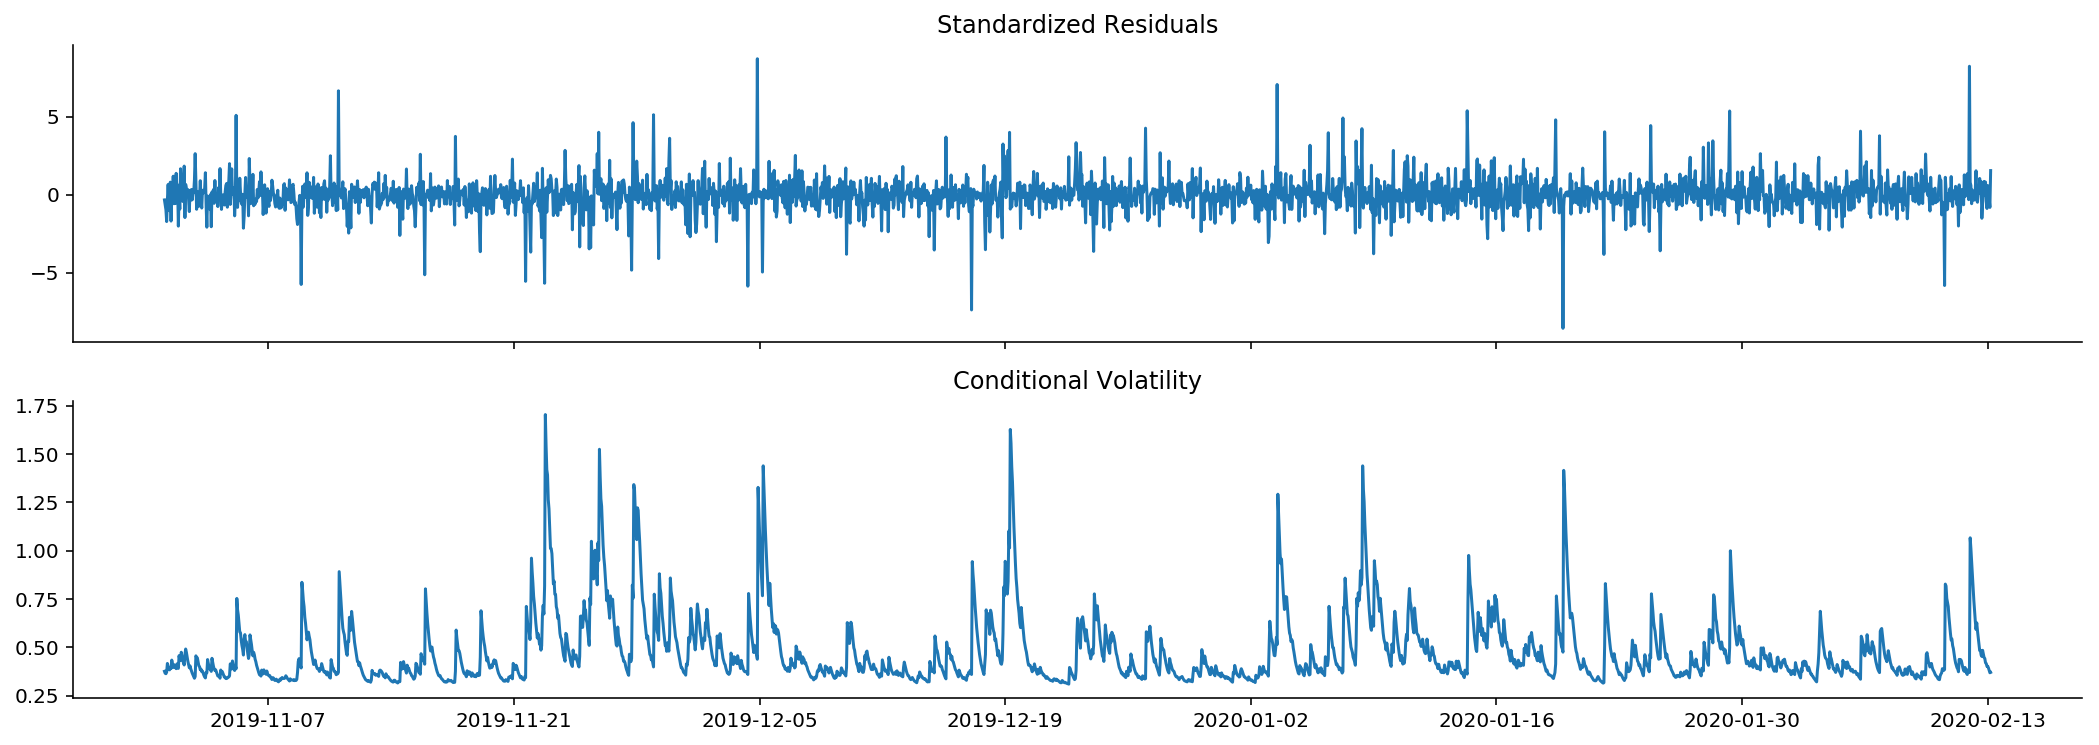

In [73]:
fig = res_GARCH.plot()# standardized residual
fig.set_size_inches(18, 6)# conditional volatility
sns.despine()

In [64]:
start_date = '2020-02-01 00:00:00+08:00'
trained_GARCH2 = arch_model(training_arch.loc[start_date:], mean='AR',lags=model_lags, vol='GARCH', p=model_lags, o=1, q=1, dist='ged',power=1.0)
res_GARCH = trained_GARCH2.fit()
fig = res_GARCH.hedgehog_plot()  # volatility
fig.set_size_inches(18, 4)
sns.despine()

Iteration:      1,   Func. Count:      9,   Neg. LLF: 139.85545993093126
Iteration:      2,   Func. Count:     22,   Neg. LLF: 139.76683299185967
Iteration:      3,   Func. Count:     33,   Neg. LLF: 138.48630578071786
Iteration:      4,   Func. Count:     44,   Neg. LLF: 138.20502371597487
Iteration:      5,   Func. Count:     55,   Neg. LLF: 137.12346107415976
Iteration:      6,   Func. Count:     65,   Neg. LLF: 135.0671328055064
Iteration:      7,   Func. Count:     75,   Neg. LLF: 131.4754631536156
Iteration:      8,   Func. Count:     85,   Neg. LLF: 131.10061367361058
Iteration:      9,   Func. Count:     95,   Neg. LLF: 131.04055627553464
Iteration:     10,   Func. Count:    105,   Neg. LLF: 131.0151406926467
Iteration:     11,   Func. Count:    114,   Neg. LLF: 131.00132848369896
Iteration:     12,   Func. Count:    123,   Neg. LLF: 130.99311855563695
Iteration:     13,   Func. Count:    134,   Neg. LLF: 130.9926464049497
Iteration:     14,   Func. Count:    143,   Neg. LLF: 1

KeyboardInterrupt: 

#### GARCH预测

In [78]:
res_GARCH.params  # 得到模型

Const            0.003273
log_...00x[1]   -0.106422
omega            0.016591
alpha[1]         0.109131
beta[1]          0.815631
nu               1.010000
Name: params, dtype: float64

$$a_t = \sigma_t \epsilon_t \\
 \sigma^2_t = \alpha_0 + \sum^m_{i=1}\alpha_i a^2_{t-i} + \sum^s_{j=1} \beta_j \sigma^2_{t-j}$$

In [128]:
ini2 = res_GARCH.conditional_volatility[-2:] #上两个条件异方差值 根据波动率方程预测 𝜎2
for i in range(predict_lag):
    new = res_GARCH.params['omega'] + res_GARCH.params['alpha[1]'] * res_GARCH.resid**2 + res_GARCH.conditional_volatility**2 * res_GARCH.params['beta[1]']
    ini2 = np.append(ini2,new)
vol_pre = ini2[-predict_lag:]
# vol_pre
compare_GARCH = pd.DataFrame()
compare_GARCH['original'] = kline_test['realized_volatility_1_hour'][:predict_lag-model_p]
compare_GARCH['predict_volatility'] = vol_pre[model_p:]
compare_GARCH.head()

,original,predict_volatility
date,,
2020-02-13 04:00:00+08:00,0.440438,0.179591
2020-02-13 05:00:00+08:00,0.446989,0.170244
2020-02-13 06:00:00+08:00,0.251623,0.155462
2020-02-13 07:00:00+08:00,0.513761,0.159956
2020-02-13 08:00:00+08:00,0.420905,0.148248


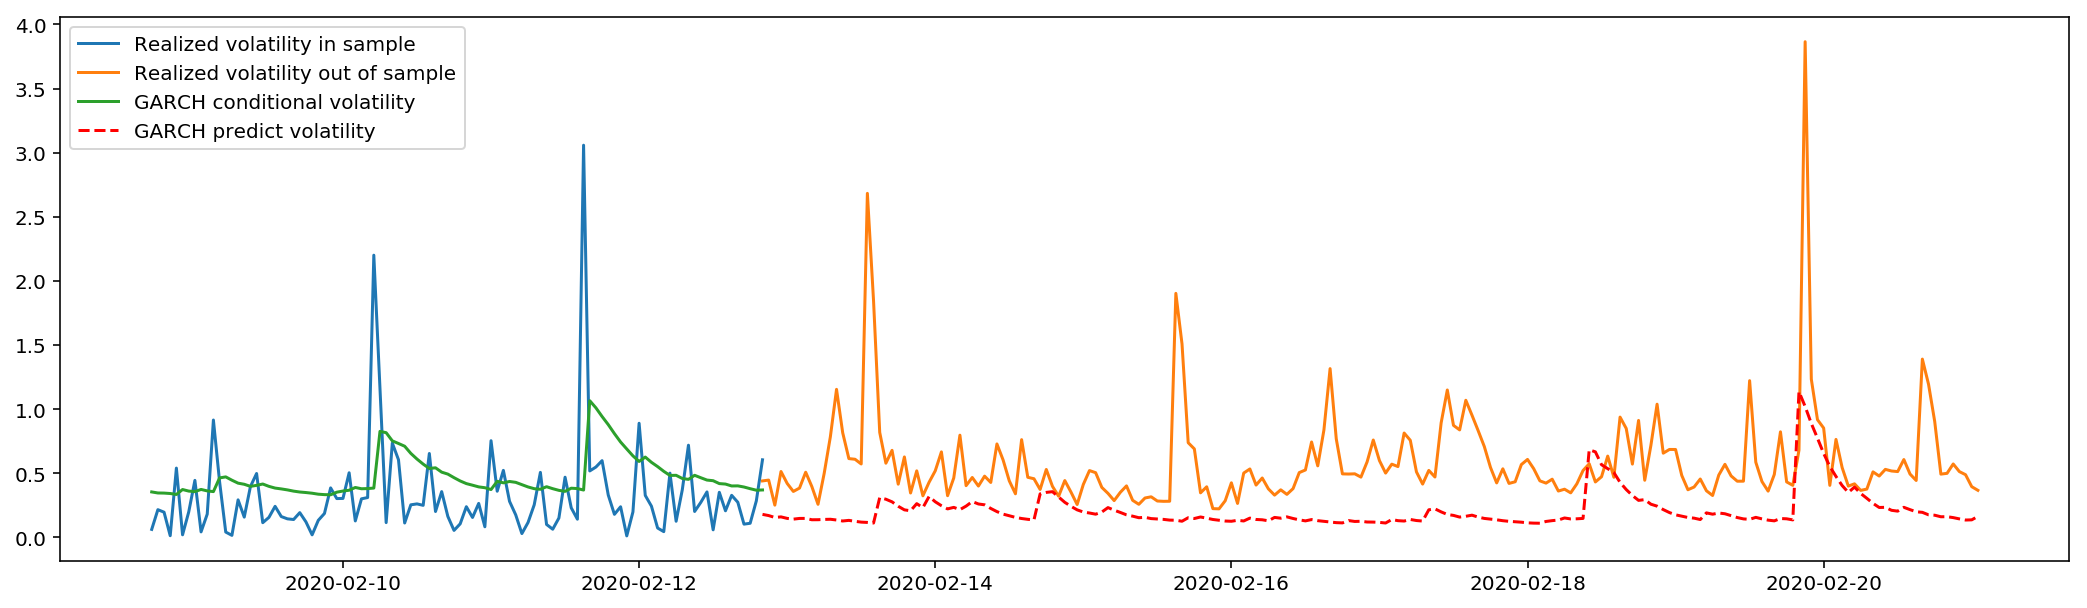

In [81]:
plt.figure(figsize=(18,5))
plt.plot(kline_train['realized_volatility_1_hour'][2400:],label='Realized volatility in sample')
plt.plot(compare_GARCH['original'], label='Realized volatility out of sample')
plt.plot(res_GARCH.conditional_volatility[2400:],label='GARCH conditional volatility')
plt.plot(compare_GARCH['predict_volatility'], '--r', label='GARCH predict volatility')
plt.legend()

## 第十步 建立EGARCH模型

In [117]:
am_EGARCH = arch_model(training_egarch, mean='AR',lags=model_lags,
                       vol='EGARCH',p=model_lags+1,o=2,q=2, 
                       dist='ged',power = 2)
res_EGARCH = am_EGARCH.fit()
res_EGARCH.summary()


Iteration:      1,   Func. Count:     12,   Neg. LLF: 1567.5717395825816
Iteration:      2,   Func. Count:     28,   Neg. LLF: 1548.1036671999536
Iteration:      3,   Func. Count:     44,   Neg. LLF: 1544.9562761592983
Iteration:      4,   Func. Count:     59,   Neg. LLF: 1541.2319078308408
Iteration:      5,   Func. Count:     74,   Neg. LLF: 1537.022734814573
Iteration:      6,   Func. Count:     90,   Neg. LLF: 1536.8251706468457
Iteration:      7,   Func. Count:    104,   Neg. LLF: 1536.0600851312813
Iteration:      8,   Func. Count:    118,   Neg. LLF: 1532.4213269918644
Iteration:      9,   Func. Count:    131,   Neg. LLF: 1512.5561471829126
Iteration:     10,   Func. Count:    144,   Neg. LLF: 1494.979338926485
Iteration:     11,   Func. Count:    157,   Neg. LLF: 1459.9565337316335
Iteration:     12,   Func. Count:    170,   Neg. LLF: 1449.9078552060294
Iteration:     13,   Func. Count:    183,   Neg. LLF: 1427.9848830675714
Iteration:     14,   Func. Count:    196,   Neg. LLF:

<class 'statsmodels.iolib.summary.Summary'>
"""
                                AR - EGARCH Model Results                                 
==========================================================================================
Dep. Variable:                    log_return_100x   R-squared:                      -0.009
Mean Model:                                    AR   Adj. R-squared:                 -0.009
Vol Model:                                 EGARCH   Log-Likelihood:               -1394.62
Distribution:      Generalized Error Distribution   AIC:                           2809.24
Method:                        Maximum Likelihood   BIC:                           2867.48
                                                    No. Observations:                 2499
Date:                            Sat, Mar 14 2020   Df Residuals:                     2489
Time:                                    14:05:52   Df Model:                           10
                                   Mean Model                                  
===============================================================================
                    coef    std err          t      P>|t|      95.0% Conf. Int.
-------------------------------------------------------------------------------
Const         2.8269e-03  2.728e-04     10.362  3.676e-25 [2.292e-03,3.362e-03]
log_...00x[1]    -0.1094  5.059e-04   -216.254      0.000     [ -0.110, -0.108]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega         -0.1190  5.784e-02     -2.056  3.974e-02   [ -0.232,-5.583e-03]
alpha[1]       0.3121  5.091e-02      6.131  8.720e-10      [  0.212,  0.412]
alpha[2]       0.0696  9.129e-02      0.763      0.446      [ -0.109,  0.249]
gamma[1]   8.5625e-03  2.918e-02      0.293      0.769 [-4.863e-02,6.575e-02]
gamma[2]      -0.0145  3.407e-02     -0.427      0.670 [-8.132e-02,5.224e-02]
beta[1]        0.2167      0.159      1.360      0.174   [-9.572e-02,  0.529]
beta[2]        0.6865      0.143      4.817  1.458e-06      [  0.407,  0.966]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             1.0100  4.490e-02     22.496 4.524e-112 [  0.922,  1.098]
========================================================================

Covariance estimator: robust
"""

In [20]:
# res_EGARCH.forecast()
# len(training_arch)
pre_ARCH = res_EGARCH.forecast(horizon=5, start=2400, method='simulation')
# pre_ARCH.variance[2400:]#.plot()

In [23]:
pre_ARCH.variance[2400:]#.columns

,h.1,h.2,h.3,h.4,h.5
date,,,,,
2020-02-09 01:00:00+08:00,0.134757,0.156473,0.179215,0.197538,0.217847
2020-02-09 02:00:00+08:00,0.140073,0.160502,0.179073,0.198816,0.218897
2020-02-09 03:00:00+08:00,0.138827,0.159013,0.179166,0.199170,0.218631
2020-02-09 04:00:00+08:00,0.116834,0.136587,0.155770,0.175096,0.193135
2020-02-09 05:00:00+08:00,0.172020,0.190943,0.211022,0.228250,0.246402
2020-02-09 06:00:00+08:00,0.141495,0.162186,0.180913,0.201171,0.220103
2020-02-09 07:00:00+08:00,0.143705,0.162460,0.184479,0.201410,0.216606
2020-02-09 08:00:00+08:00,0.178192,0.196971,0.216103,0.234752,0.253804
2020-02-09 09:00:00+08:00,0.153212,0.172765,0.192870,0.214600,0.231255


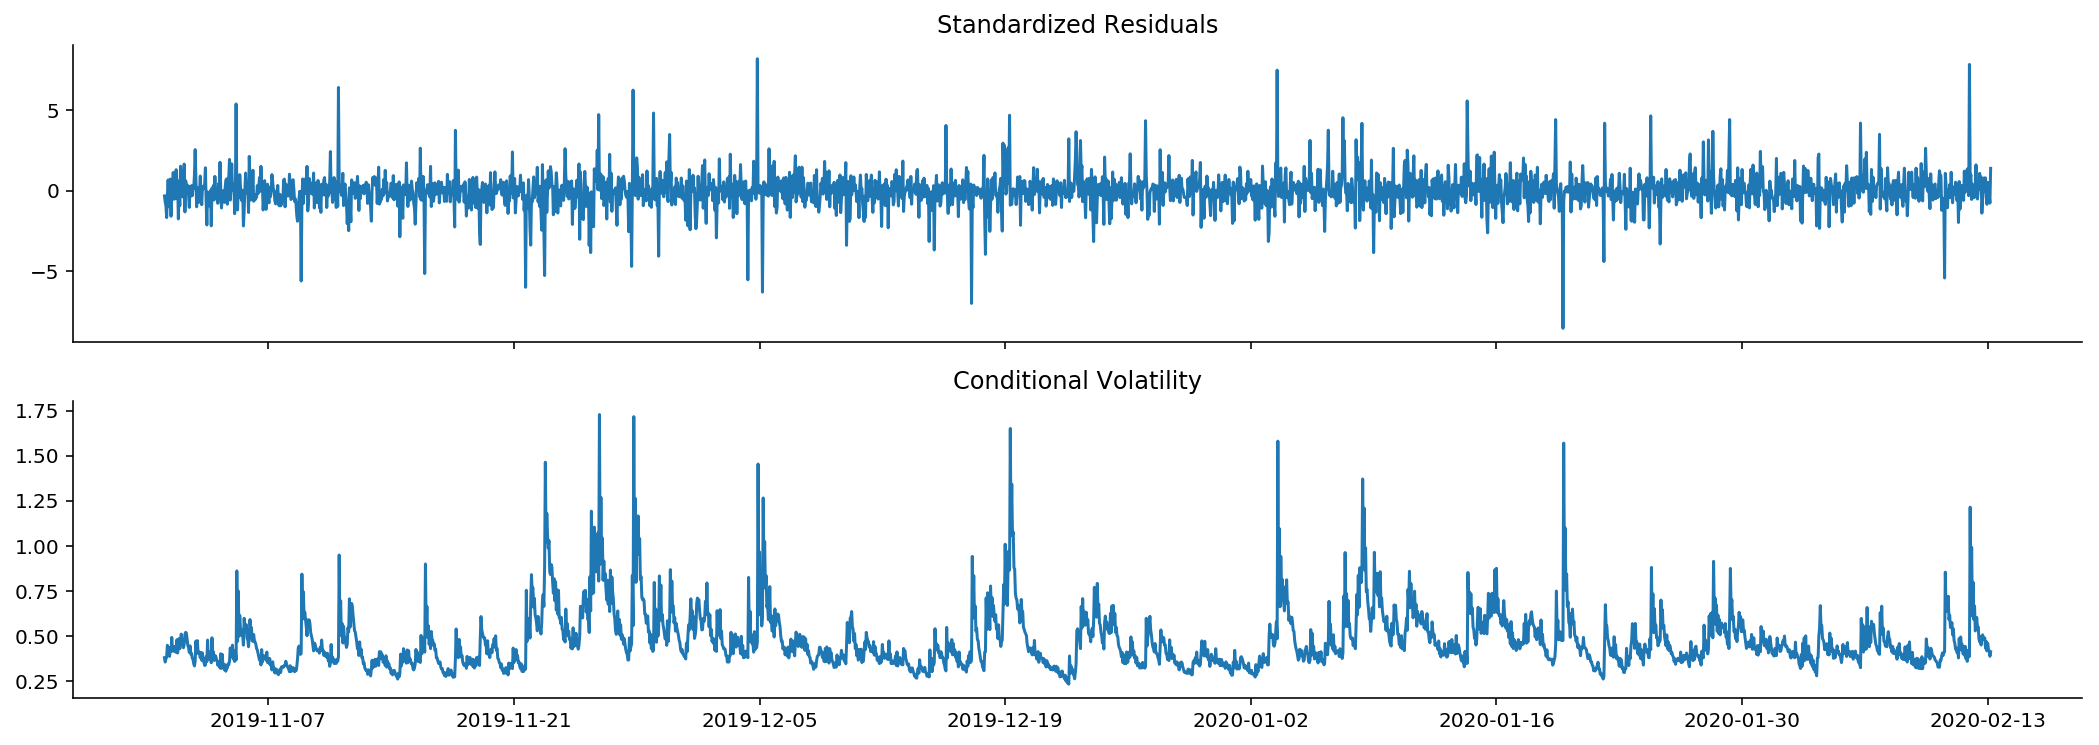

In [129]:
fig = res_EGARCH.plot()# standardized residual
fig.set_size_inches(18, 6)# conditional volatility
sns.despine()

#### EGARCH预测

In [95]:
res_EGARCH.params

Const            0.002782
log_...00x[1]   -0.104599
omega           -0.087856
alpha[1]         0.245512
beta[1]          0.930388
nu               1.010000
Name: params, dtype: float64

In [132]:
ini2 = res_EGARCH.conditional_volatility[-2:]
for i in range(predict_lag):
    new = res_EGARCH.params['omega']+res_EGARCH.params['alpha[1]']*(np.abs(res_EGARCH.resid/res_EGARCH.conditional_volatility)-np.sqrt(2/np.pi))+res_EGARCH.params['gamma[1]']*res_EGARCH.resid/res_EGARCH.conditional_volatility**2+res_EGARCH.params['beta[1]']*np.log(res_EGARCH.conditional_volatility**2)
    ini2 = np.append(ini2, np.exp(new))
vol_pre = ini2[-predict_lag:]
vol_pre
compare_EGARCH = pd.DataFrame()
compare_EGARCH['original'] = kline_test['realized_volatility_1_hour'][:predict_lag-model_p]
compare_EGARCH['predict_volatility'] = vol_pre[model_p:]
compare_EGARCH
compare_EGARCH.head()

,original,predict_volatility
date,,
2020-02-13 04:00:00+08:00,0.440438,0.768833
2020-02-13 05:00:00+08:00,0.446989,0.596606
2020-02-13 06:00:00+08:00,0.251623,0.473836
2020-02-13 07:00:00+08:00,0.513761,0.617716
2020-02-13 08:00:00+08:00,0.420905,0.509307


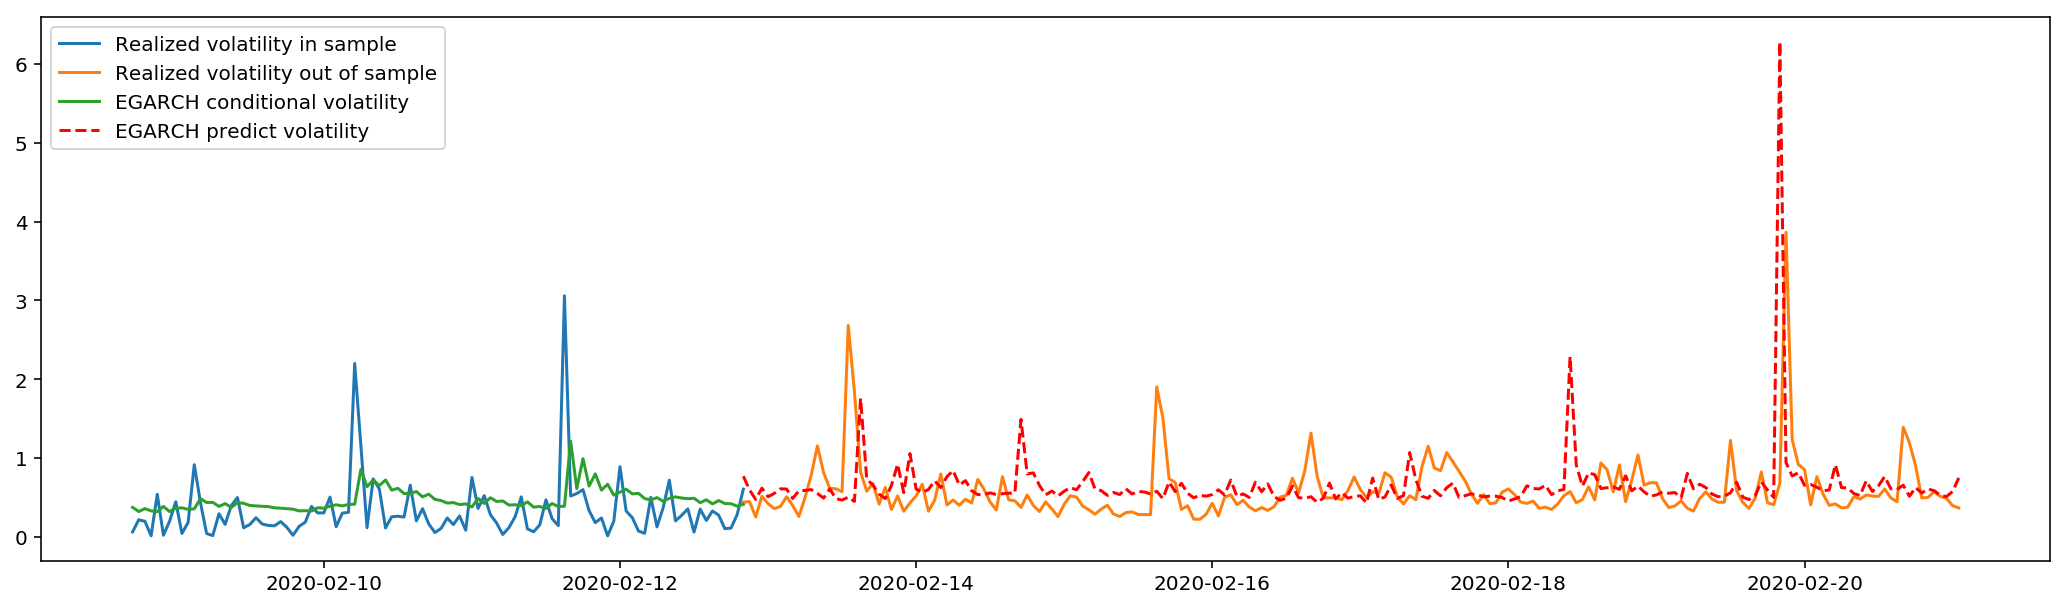

In [133]:
plt.figure(figsize=(18,5))
plt.plot(kline_train['realized_volatility_1_hour'][2400:],label='Realized volatility in sample')
plt.plot(compare_EGARCH['original'], label='Realized volatility out of sample')
plt.plot(res_EGARCH.conditional_volatility[2400:],label='EGARCH conditional volatility')
plt.plot(compare_EGARCH['predict_volatility'], '--r', label='EGARCH predict volatility')
plt.legend()

## 第十一步 预测模型比较结果

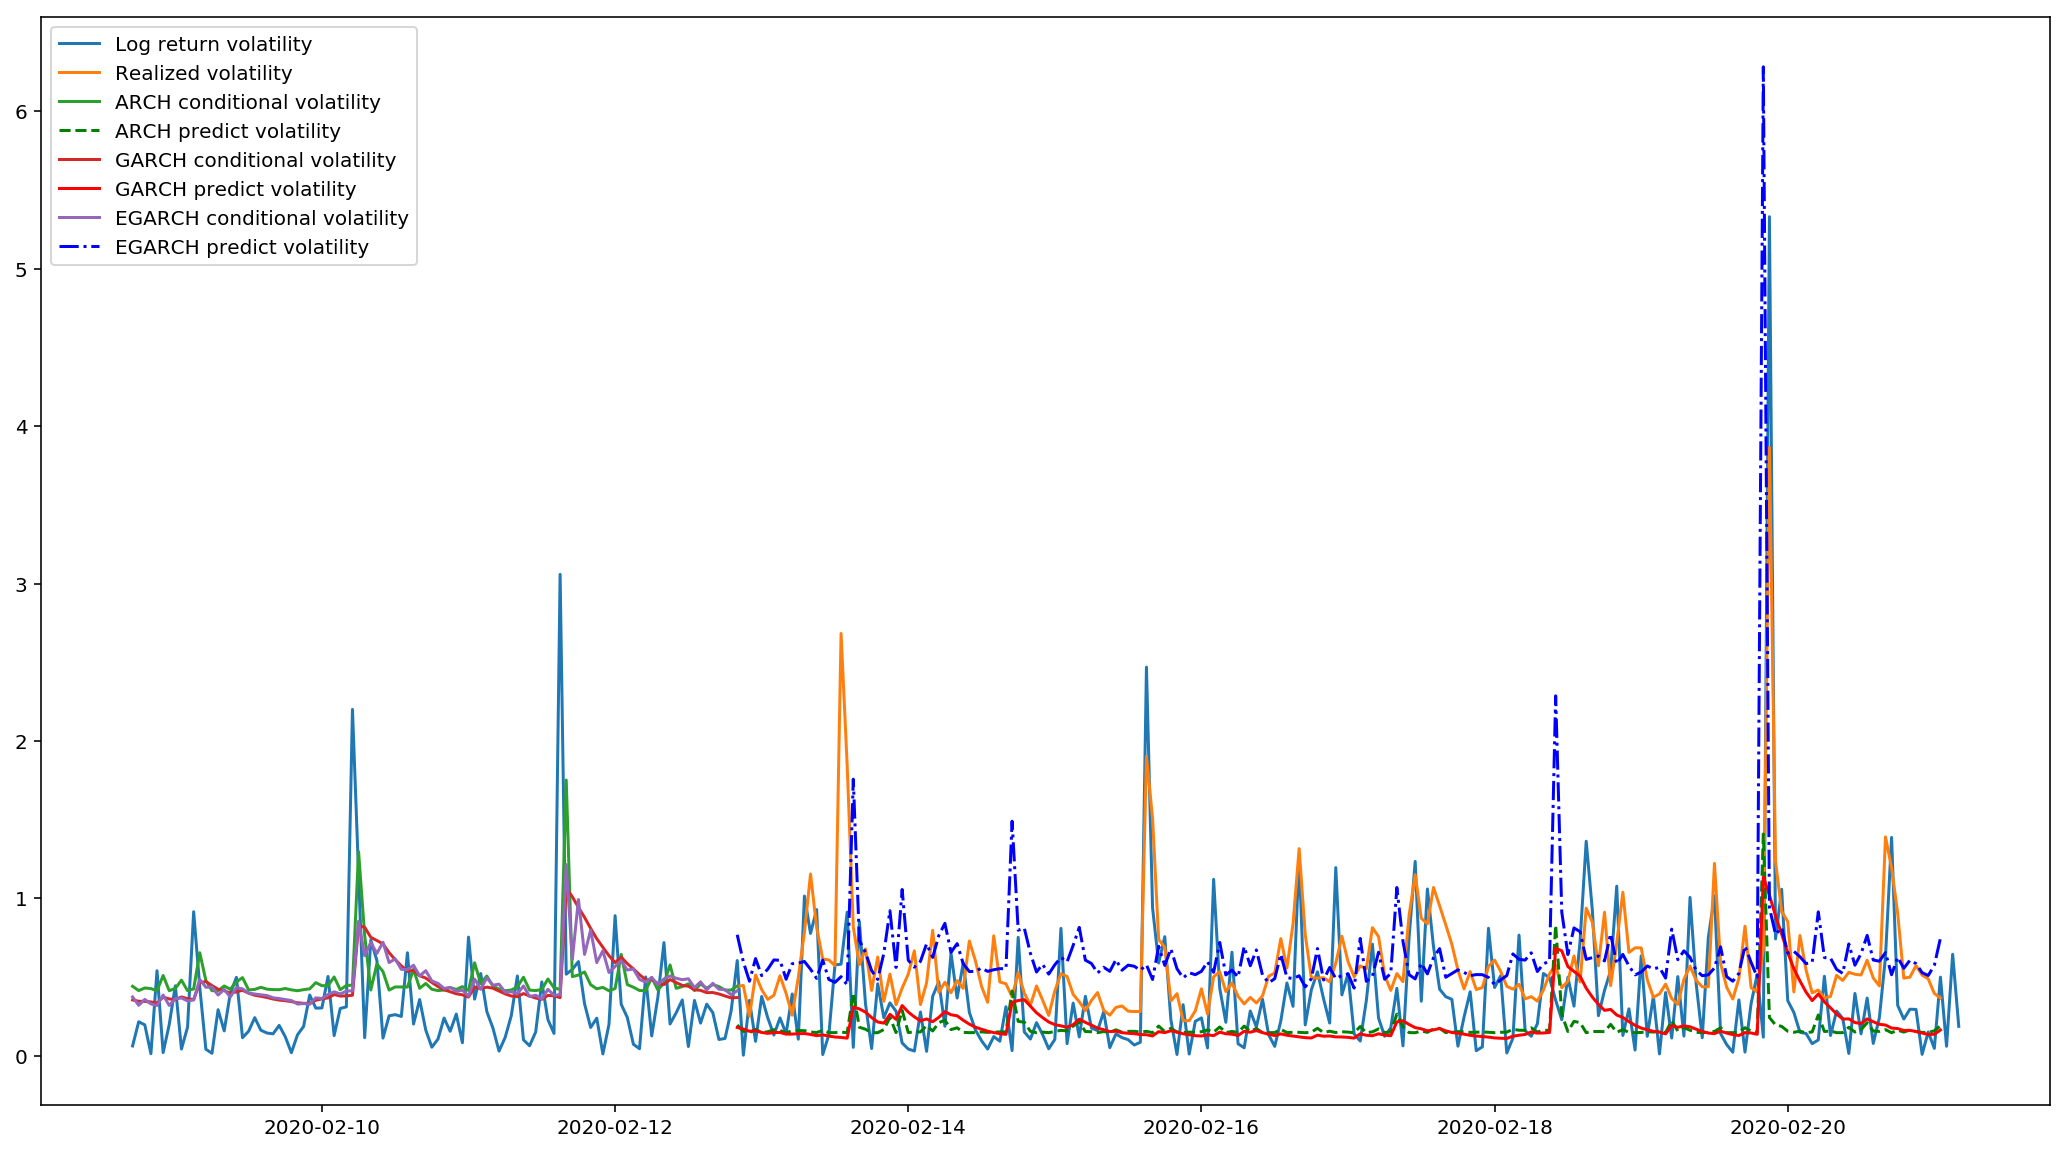

In [130]:
plt.figure(figsize=(18,10))
plt.plot(kline_all['realized_volatility_1_hour'][2400:2700],label='Log return volatility')
plt.plot(compare_ARCH['original'], label='Realized volatility')
plt.plot(res_ARCH.conditional_volatility[2400:],label='ARCH conditional volatility')
plt.plot(compare_ARCH['predict_volatility'], '--g', label='ARCH predict volatility')
plt.plot(res_GARCH.conditional_volatility[2400:],label='GARCH conditional volatility')
plt.plot(compare_GARCH['predict_volatility'], '-r', label='GARCH predict volatility')
plt.plot(res_EGARCH.conditional_volatility[2400:],label='EGARCH conditional volatility')
plt.plot(compare_EGARCH['predict_volatility'], '-.b', label='EGARCH predict volatility')
plt.legend()

In [131]:
# 评价MSE，0的MSE是估计器将以完美的精度预测参数的观测值，这将是一个理想的场景但通常不可能。
compare_ARCH_X = pd.DataFrame()
compare_ARCH_X['Model'] = ['ARCH','GARCH','EGARCH']
compare_ARCH_X['RMSE'] = [get_rmse(compare_ARCH['predict_volatility'], compare_ARCH['original']),get_rmse(compare_GARCH['predict_volatility'], compare_GARCH['original']),get_rmse(compare_EGARCH['predict_volatility'], compare_EGARCH['original'])]
compare_ARCH_X['MAPE'] = [get_mape(compare_ARCH['predict_volatility'], compare_ARCH['original']),get_mape(compare_GARCH['predict_volatility'], compare_GARCH['original']),get_mape(compare_EGARCH['predict_volatility'], compare_EGARCH['original'])]
compare_ARCH_X['MASE'] = [get_mase(compare_ARCH['predict_volatility'], compare_ARCH['original']),get_mase(compare_GARCH['predict_volatility'], compare_GARCH['original']),get_mase(compare_EGARCH['predict_volatility'], compare_EGARCH['original'])]
compare_ARCH_X

,Model,RMSE,MAPE,MASE
0,ARCH,0.568795,259.604170,0.997880
1,GARCH,0.524654,237.351476,0.998373
2,EGARCH,0.579677,40.906497,1.000754


In [144]:
compare_ARCH_X = pd.DataFrame()
compare_ARCH_X['original']=kline_test['realized_volatility_1_hour'][:predict_lag-model_p]
compare_ARCH_X['arch']=compare_ARCH['predict_volatility']
compare_ARCH_X['arch_diff']=compare_ARCH_X['original']-np.abs(compare_ARCH_X['arch'])
compare_ARCH_X['garch']=compare_GARCH['predict_volatility']
compare_ARCH_X['garch_diff']=compare_ARCH_X['original']-np.abs(compare_ARCH_X['garch'])
compare_ARCH_X['egarch']=compare_EGARCH['predict_volatility']
compare_ARCH_X['egarch_diff']=compare_ARCH_X['original']-np.abs(compare_ARCH_X['egarch'])
compare_ARCH_X.head(10)

,original,arch,arch_diff,garch,garch_diff,egarch,egarch_diff
date,,,,,,,
2020-02-13 04:00:00+08:00,0.440438,0.195345,0.245093,0.179591,0.260847,0.768833,-0.328395
2020-02-13 05:00:00+08:00,0.446989,0.155515,0.291473,0.170244,0.276745,0.596606,-0.149618
2020-02-13 06:00:00+08:00,0.251623,0.146556,0.105067,0.155462,0.096161,0.473836,-0.222214
2020-02-13 07:00:00+08:00,0.513761,0.167271,0.346490,0.159956,0.353805,0.617716,-0.103955
2020-02-13 08:00:00+08:00,0.420905,0.148029,0.272875,0.148248,0.272657,0.509307,-0.088403
2020-02-13 09:00:00+08:00,0.358325,0.152635,0.205690,0.142378,0.215947,0.550563,-0.192238
2020-02-13 10:00:00+08:00,0.384682,0.165538,0.219145,0.147900,0.236782,0.609029,-0.224347
2020-02-13 11:00:00+08:00,0.508373,0.160274,0.348098,0.148198,0.360174,0.606649,-0.098276
2020-02-13 12:00:00+08:00,0.396242,0.146751,0.249491,0.137636,0.258605,0.486192,-0.089951


In [149]:
delta_arch = compare_ARCH_X['arch'] - compare_ARCH_X['original']
adjR_arch = 1 - delta_arch.var()/compare_ARCH_X['original'].var()

delta_garch = compare_ARCH_X['garch'] - compare_ARCH_X['original']
adjR_garch = 1 - delta_garch.var()/compare_ARCH_X['original'].var()

delta_egarch = compare_ARCH_X['egarch'] - compare_ARCH_X['original']
adjR_egarch = 1 - delta_egarch.var()/compare_ARCH_X['original'].var()

vo_adjR_test=pd.DataFrame(index=['ARCH','GARCH','EGARCH'],columns=['adjR2'])
vo_adjR_test['adjR2']['ARCH']=adjR_arch**2
vo_adjR_test['adjR2']['GARCH']=adjR_garch**2
vo_adjR_test['adjR2']['EGARCH']=adjR_egarch**2
vo_adjR_test

,adjR2
ARCH,0.00340361
GARCH,0.00473182
EGARCH,1.63396


In [143]:

compare_ARCH_X_diff = pd.DataFrame(index=['ARCH','GARCH','EGARCH'], columns=['head 10 steps', 'head all 200 steps'])
compare_ARCH_X_diff['head 10 steps']['ARCH'] = np.mean(compare_ARCH_X['arch_diff'][:10])
compare_ARCH_X_diff['head all 200 steps']['ARCH'] = np.mean(compare_ARCH_X['arch_diff'])
compare_ARCH_X_diff['head 10 steps']['GARCH'] = np.mean(compare_ARCH_X['garch_diff'][:10])
compare_ARCH_X_diff['head all 200 steps']['GARCH'] = np.mean(compare_ARCH_X['garch_diff'])
compare_ARCH_X_diff['head 10 steps']['EGARCH'] = np.mean(compare_ARCH_X['egarch'][:10])
compare_ARCH_X_diff['head all 200 steps']['EGARCH'] = np.abs(np.mean(compare_ARCH_X['egarch_diff']))
compare_ARCH_X_diff

,head 10 steps,head all 200 steps
ARCH,0.238357,0.411204
GARCH,0.245185,0.373328
EGARCH,0.580364,0.0597221
